ДЗ выполнил Югай Данила, мои tgдля связи: Dangennadevich

### Домашня работа 2.
### Логистическая регрессия. Работа с признаками


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 15 баллов. Можно получить 4.5 бонусных балла.

Неэффективная реализация кода может негативно отразиться на оценке.

In [1]:
print('Всем удачи!👒 Тут она точно пригодится.')

Всем удачи!👒 Тут она точно пригодится.


In [2]:
%pylab inline
import pandas as pd
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
import warnings
warnings.filterwarnings("ignore")

## Часть 1. Логистическая регрессия своими руками (4 балла)

Реализуйте логистическую регрессию, обучаемую с помощью:

**Задание 1 (1.5 балла). Градиентного спуска**

**Задание 2 (1.5 балла). Стохастического градиентного спуска**

Во всех пунктах необходимо соблюдать следующие условия:
- Градиентный спуск необходимо записать в векторном виде
- Циклы средствами python допускается использовать только для итераций градиентного спуска;
- В качестве критерия останова необходимо использовать (одновременно):

        проверку на евклидову норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$) задаваемого параметром `tolerance`;


        достижение максимального числа итераций (например, 10000), задаваемого параметром `max_iter`.

Чтобы проследить, что оптимизационный процесс действительно сходится, будем использовать атрибут класса loss_history. В нём после вызова метода fit должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту);

Инициализировать веса можно случайным образом или нулевым вектором.

Полезно [почитать](https://scikit-learn.org/stable/developers/develop.html).

Еще у меня англ не разговорный, поэтому я иногда писал на нем, иногда забивал :) 

In [4]:
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self, gd_type='full', 
                 tolerance=1e-4, max_iter=1000, w0=None, eta=1e-2):
        """
        gd_type: 'full' or 'stochastic' 
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) — init weights
        eta: learning rate
        print_iter: print loss at fit iter
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        #self.alpha = alpha
        self.w0 = w0
        self.w = None
        self.eta = eta
        self.loss_history = [] # list of loss function values at each training iteration

    
    def fit(self, X: np.array, y: np.array, print_iter: bool = True):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        print_iter: print loss at every step else not
        ---
        output: self
        """

        # Инициализируем вектор весов - если он не передан - wi = 0.01, иначе полученные значения
        if self.w0 is None:
            self.w = np.ones(X.shape[1])*0.01
        else:
            self.w = self.w0

        # Алгоритм градиента
        for i in range(self.max_iter): # Критерий остановы на  макс число итераций
            
            # stochastic GD or CLasiic GD
            if self.gd_type == 'stochastic':
                obj = np.random.choice(len(y), size=10) # 10 Random object
                X_sample = X[obj]
                y_sample = y[obj]
                grad = self.calc_gradient(X_sample, y_sample)
            elif self.gd_type == 'full':
                grad = self.calc_gradient(X, y) # All object
            else:
                raise Exception("Not avaliable gradient type. Choose one of: ['stochastic', 'full']")

            # weight
            w_old = self.w # Save old weight
            self.w = w_old - self.eta * grad # New weight

            # loss
            loss = self.calc_loss(X, y) # Calculate Loss Cross entropy
            if print_iter:
                print(f'iter {i}, loss: {loss}, sum_weight: {np.abs(sum(np.abs(self.w) - np.abs(w_old)))}')
            self.loss_history.append(loss) # Add loss to histiory
            
            # stop criteria 
            if np.abs(sum(np.abs(self.w) - np.abs(w_old))) < self.tolerance: 
                break

        print('Model fitted')
        
        return self
    
    
    def predict_proba(self, X: np.array) -> np.array:
        '''Финкция логистической регресси, на вход объект и его признаки, на выходе вероятность принадлежности к 1 классу

        Вызываем ошибку, если веса не инициализированны иначе возвращаем сигмоиду
        '''
        if self.w is None:
            raise Exception('Not trained yet')

        return 1 / (1 + np.exp(np.clip(-np.dot(X, self.w), -200, 200))) # Ограничим экспоненту, что бы она не была слишком большой
    
    
    def predict(self, X: np.array) -> np.array:
        '''Поулчаем вектор предсказаний и маркируем их в класс -1 или 1

        Если предсказанный скор >= 0.5 - первый класс, иначе 1-
        '''
        if self.w is None:
            raise Exception('Not trained yet')
        
        return np.where(self.predict_proba(X) >= 0.5, 1, -1)
    
    def calc_gradient(self, X: np.array, y: np.array) -> np.array:
        """ Рассчитываем градиент - производная кросс энтропии
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        return np.dot(X.T, (np.dot(X, self.w) - y)) / len(y) # Градиент кросс-энтропии

    def calc_loss(self, X: np.array, y: np.array) -> np.array:
        """ Рассчитываем функцию потерь - кросс энтропия
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float 
        """ 

        y_pred = self.predict_proba(X)

        # Цыганские фокусы
        # Заменим 0 на очень маленькое число
        y_pred = np.where(y_pred == 0, + 1e-8, y_pred)
        # Заменим 1 на очень близкое к 1 число
        y_pred = np.where(y_pred == 1, 1 - 1e-8, y_pred)
        
        return -np.mean(y * np.log(y_pred ) + (1 - y) * np.log(1 - y_pred))
        

Синтетические данные

In [5]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [216]:
X, y = make_classification(
    n_samples=100000, n_features=20, n_informative=10, n_redundant=10,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

**Важно:** далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

**Задание 3 (1 балл)**

Обучите логистическую регрессию на синтетических данных.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve

In [218]:
# Для сравнения обучу модель sklearn
sklrn_lr = LogisticRegression()
sklrn_lr.fit(X=X_train, y=y_train)

LogisticRegression()

In [219]:
# Моя LR модель (base GD)
lr = LogReg(eta=0.001)
lr.fit(X=X_train, y=y_train)

iter 0, loss: 0.6760268932780298, sum_weight: 0.001679206747893111
iter 1, loss: 0.6709313758432893, sum_weight: 0.0016200554710124153
iter 2, loss: 0.666216041334072, sum_weight: 0.001563985492536453
iter 3, loss: 0.6618477812987504, sum_weight: 0.0015108067550587247
iter 4, loss: 0.6577967089970849, sum_weight: 0.0014603413092322036
iter 5, loss: 0.6540358284783276, sum_weight: 0.0014124225450660262
iter 6, loss: 0.6505407367128179, sum_weight: 0.0013668944716438195
iter 7, loss: 0.6472893560834002, sum_weight: 0.0013236110422319234
iter 8, loss: 0.6442616945806265, sum_weight: 0.001282435521934625
iter 9, loss: 0.6414396311414232, sum_weight: 0.0002646575813341572
iter 10, loss: 0.6388067237054608, sum_weight: 0.0004870989357085983
iter 11, loss: 0.6363480377217736, sum_weight: 0.0010263565872552216
iter 12, loss: 0.6340499930087974, sum_weight: 0.0016872760905814236
iter 13, loss: 0.6319002270454323, sum_weight: 0.001612080885248069
iter 14, loss: 0.6298874729429451, sum_weight: 0.

LogReg(eta=0.001)

In [220]:
# Моя LR модель (SGD)
lr_sgd = LogReg(gd_type='stochastic', eta=0.003)#
lr_sgd.fit(X=X_train, y=y_train)

iter 0, loss: 0.68077345566832, sum_weight: 0.0022716179714685793
iter 1, loss: 0.6523288751615368, sum_weight: 0.018852904258275512
iter 2, loss: 0.6428204630114202, sum_weight: 0.007967078268904746
iter 3, loss: 0.6311129780293544, sum_weight: 0.011688693943851651
iter 4, loss: 0.6284459459738866, sum_weight: 0.0036724467088168934
iter 5, loss: 0.6160276008339944, sum_weight: 0.009645229446265103
iter 6, loss: 0.6323339906262558, sum_weight: 0.011431604783077445
iter 7, loss: 0.6328041763127769, sum_weight: 0.0016301193388093506
iter 8, loss: 0.6365193248091322, sum_weight: 0.0013098437818096055
iter 9, loss: 0.6264398668286845, sum_weight: 0.017466571335663882
iter 10, loss: 0.6094310516473836, sum_weight: 0.015313408688418325
iter 11, loss: 0.6088081275246875, sum_weight: 0.0009203109696437355
iter 12, loss: 0.6086983692871836, sum_weight: 0.005594208553451658
iter 13, loss: 0.5993448634120503, sum_weight: 0.014029998472938952
iter 14, loss: 0.606339661757557, sum_weight: 0.0060974

LogReg(eta=0.003, gd_type='stochastic')

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые. Проинтерпретируйте результат.

In [221]:
y_pred_sklrn = sklrn_lr.predict_proba(X_test)[:,1]
y_pred = lr.predict_proba(X_test)
y_pred_sgd = lr_sgd.predict_proba(X_test)

In [231]:
# ROC-AUC
my_roc = round(roc_auc_score(y_test, y_pred),3)
print('My model', my_roc)

sgd_roc = round(roc_auc_score(y_test, y_pred_sgd),3)
print('My model sgd', sgd_roc)

sklrn_roc = round(roc_auc_score(y_test, y_pred_sklrn),3)
print('sklearn model', sklrn_roc)

My model 0.855
My model sgd 0.834
sklearn model 0.926


In [237]:
# PR-AUC
my_pr = round(average_precision_score(y_test, y_pred),3)
print('My model', my_pr)

sgd_pr = round(average_precision_score(y_test, y_pred_sgd),3)
print('My model sgd', sgd_pr)

sklearn_pr = round(average_precision_score(y_test, y_pred_sklrn),3)
print('sklearn model', sklearn_pr)

My model 0.826
My model sgd 0.802
sklearn model 0.925


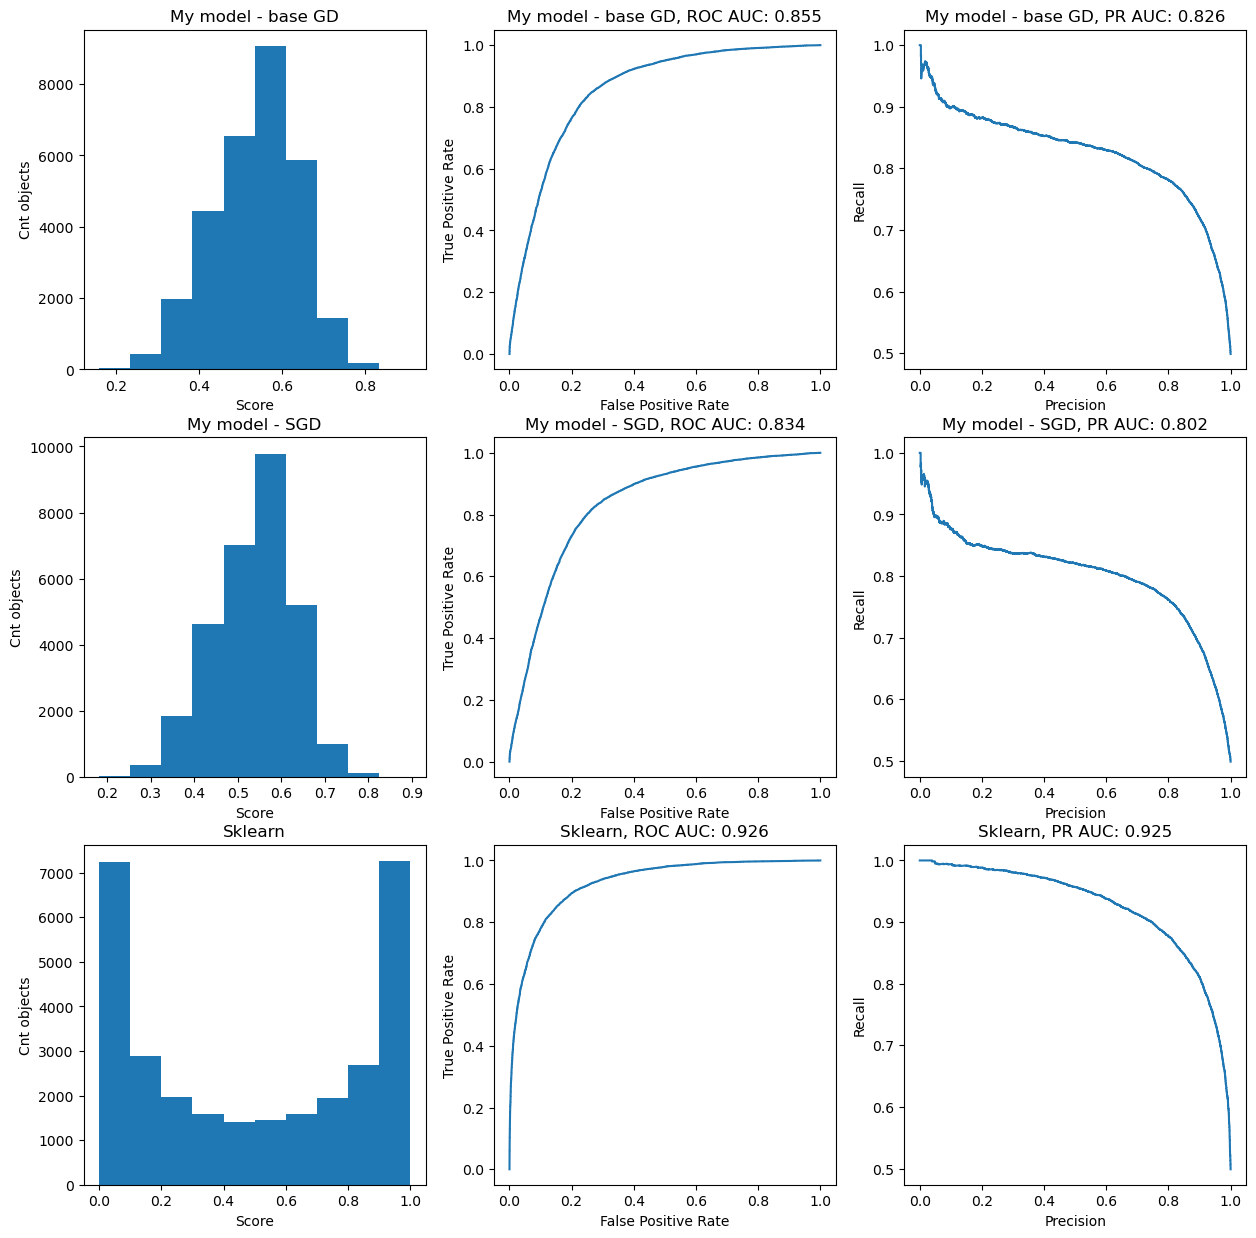

In [239]:
# Визуализация

fig, axs = plt.subplots(3,3, figsize=(15,15))


axs[0][0].hist(y_pred)
axs[0][0].set_title('My model - base GD')

axs[1][0].hist(y_pred_sgd)
axs[1][0].set_title('My model - SGD')

axs[2][0].hist(y_pred_sklrn)
axs[2][0].set_title('Sklearn')

for i in range(3):
    axs[i][0].set_xlabel('Score')
    axs[i][0].set_ylabel('Cnt objects')

# ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
fpr_sgd, tpr_sgd, _ = roc_curve(y_test, y_pred_sgd)
fpr_sclearn, tpr_sclearn, _ = roc_curve(y_test, y_pred_sklrn)

axs[0][1].plot(fpr,tpr)
axs[0][1].set_title(f'My model - base GD, ROC AUC: {my_roc}')

axs[1][1].plot(fpr_sgd, tpr_sgd)
axs[1][1].set_title(f'My model - SGD, ROC AUC: {sgd_roc}')

axs[2][1].plot(fpr_sclearn, tpr_sclearn)
axs[2][1].set_title(f'Sklearn, ROC AUC: {sklrn_roc}')

for i in range(3):
    axs[i][1].set_xlabel('False Positive Rate')
    axs[i][1].set_ylabel('True Positive Rate')

# PR-AUC
my_precision, my_recall, _ = precision_recall_curve(y_test, y_pred)
sgd_precision, sgd_recall, _ = precision_recall_curve(y_test, y_pred_sgd)
sklen_precision, sklen_recall, _ = precision_recall_curve(y_test, y_pred_sklrn)

axs[0][2].plot(my_recall, my_precision)
axs[0][2].set_title(f'My model - base GD, PR AUC: {my_pr}')

axs[1][2].plot(sgd_recall, sgd_precision)
axs[1][2].set_title(f'My model - SGD, PR AUC: {sgd_pr}')

axs[2][2].plot(sklen_recall, sklen_precision)
axs[2][2].set_title(f'Sklearn, PR AUC: {sklearn_pr}')

for i in range(3):
    axs[i][2].set_xlabel('Precision')
    axs[i][2].set_ylabel('Recall')

plt.show()

___Выводы:___ Мне не очень нравится распределение скоров моих моделей - в отличии от sklearn они не выдиляют уверенно ни один их классов, хотя sklearn это удается и достаточно не плохо. Как и писал ранее - качество SGD модели зависит от итерации, так как есть рандомная составляющаяя в подборе объектов для обучения - я делал несколько итераций и сейчас зафиксирован, пожалуй, лучший результат. Класический GD побить не удалось. В целом результаты не плохие, например рок аук 0,83 и 0,85 показывает, что модели достаточно не плохо ранжируют клиентов, но по PR AUC заметно большое различие с реализацией SKLEARN - мои модели не могут поддерживать максимально высокий охват класса (recall) при росте точности (precision) то есть когда мы уже не всех маркируем как 1 класс. Но опять же - не выглядит плохо.

## Часть 2. Работа с категориальными переменными (3 балла)

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные с конкурса  [Kaggle Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction) (вам нужна только обучающая выборка). Задача состоит в определении водителей, которые в ближайший год воспользуются своей автомобильной страховкой (бинарная классификация). Но для нас важна будет не сама задача, а только её данные. При этом для задания мы немного модифицируем датасет.

In [240]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

Пересемплируем выборку так, чтобы положительных и отрицательных объектов в выборке было одинаковое число. Разделим на обучающую и тестовую выборки.


In [241]:
# some resampling
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

**Задание 5 (0 баллов).** Посчитайте качество (в этом задании будем работать c ROC-AUC) на исходных признаках при применении логистической регрессии.

In [251]:
%%time
# Моя модель 
lr = LogReg(eta=0.0001)
lr.fit(X=X_train.values, y=y_train)

iter 0, loss: 0.826198421605626, sum_weight: 0.020255180103194072
iter 1, loss: 0.7695791541884767, sum_weight: 0.005549820132445513
iter 2, loss: 0.7498056539136895, sum_weight: 0.0015348817352100444
iter 3, loss: 0.7420350009751733, sum_weight: 0.0012333267401370479
iter 4, loss: 0.7386622690215311, sum_weight: 0.0010905104994331939
iter 5, loss: 0.7370631600845113, sum_weight: 0.0010194924705326748
iter 6, loss: 0.7362231666469726, sum_weight: 0.0009809915835908185
iter 7, loss: 0.7357192593858076, sum_weight: 0.0009572595355737115
iter 8, loss: 0.7353675157051001, sum_weight: 0.0009402766317487743
iter 9, loss: 0.735086273924229, sum_weight: 0.0009264186158412617
iter 10, loss: 0.734838897717791, sum_weight: 0.000914047120769975
iter 11, loss: 0.7346088551241803, sum_weight: 0.0009024210237669359
iter 12, loss: 0.7343886500518633, sum_weight: 0.0008912045917939199
iter 13, loss: 0.7341748600905161, sum_weight: 0.0008802452593898915
iter 14, loss: 0.7339659022762335, sum_weight: 0.0

LogReg(eta=0.0001)

In [206]:
# Sklearn
sklrn_lr = LogisticRegression()
sklrn_lr.fit(X=X_train, y=y_train)

LogisticRegression()

In [207]:
# predict scores
pred = sklrn_lr.predict_proba(X_test)[:,1]
pred_my_model = lr.predict_proba(X_test)

In [212]:
# ROC AUC
print(f'Sklearn ROC-AUC {roc_auc_score(y_test, pred)}')
print(f'My model ROC-AUC {roc_auc_score(y_test, pred_my_model)}')

Sklearn ROC-AUC 0.6236832877810393
My model ROC-AUC 0.5634154737131828


In [213]:
# PR AUC
print(f'Sklearn PR-AUC {average_precision_score(y_test, pred)}')
print(f'My model PR-AUC {average_precision_score(y_test, pred_my_model)}')

Sklearn PR-AUC 0.6123242211548926
My model PR-AUC 0.5589235351352608


**Задание 6 (0.5 балла).** Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на обучение модели.

In [11]:
from sklearn.preprocessing import OneHotEncoder

In [245]:
# Копии для реализации  ldbel encoder
X_train_ohe = X_train.copy()
X_test_ohe = X_test.copy()

In [246]:
cat_cols = [
    'ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 
    'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 
    'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 
    'ps_car_10_cat', 'ps_car_11_cat',
]

In [247]:
ohe = OneHotEncoder(sparse=False)

X_train_ohe_cat = ohe.fit_transform(X_train_ohe[cat_cols])
X_test_ohe_cat = ohe.transform(X_test_ohe[cat_cols])

In [248]:
# OHE DATA
X_train_ohe_cat = pd.DataFrame(X_train_ohe_cat, columns= ohe.get_feature_names_out())
X_test_ohe_cat = pd.DataFrame(X_test_ohe_cat, columns= ohe.get_feature_names_out())

In [249]:
# concat OHE data & X data
X_train_ohe = pd.concat(
    [X_train_ohe.drop(cat_cols, axis=1), X_train_ohe_cat],
    axis=1
)

X_test_ohe = pd.concat(
    [X_test_ohe.drop(cat_cols, axis=1), X_test_ohe_cat],
    axis=1
)

In [259]:
%%time
ohe_lr = LogReg(eta=0.0005) # С eta = 0.01 не сходится, с eta = 0.0001 очень долго обучается
ohe_lr.fit(X=X_train_ohe, y=y_train)

iter 0, loss: 0.778787086953598, sum_weight: 0.020993404469532413
iter 1, loss: 0.7639991855365497, sum_weight: 0.016322172810717614
iter 2, loss: 0.7533753185849206, sum_weight: 0.012687325395117107
iter 3, loss: 0.7456547125907832, sum_weight: 0.009858930923437441
iter 4, loss: 0.7399824905061092, sum_weight: 0.007658070423965352
iter 5, loss: 0.7357735775363273, sum_weight: 0.005945519708852038
iter 6, loss: 0.7326228882346564, sum_weight: 0.00461294272926813
iter 7, loss: 0.7302463366881765, sum_weight: 0.003576038763930257
iter 8, loss: 0.7284420439585001, sum_weight: 0.002769209965491879
iter 9, loss: 0.7270646831784645, sum_weight: 0.002141411959730776
iter 10, loss: 0.7260083604310767, sum_weight: 0.001652925026629295
iter 11, loss: 0.7251950605320976, sum_weight: 0.0012728416239742113
iter 12, loss: 0.7245667462165043, sum_weight: 0.0009771113264445607
iter 13, loss: 0.7240798793118569, sum_weight: 0.0007470195125483233
iter 14, loss: 0.7237015667517573, sum_weight: 0.00056800

LogReg(eta=0.0005)

In [260]:
pred = ohe_lr.predict_proba(X_test_ohe)

print(f'roc: {roc_auc_score(y_test, pred)}')
print(f'ap: {average_precision_score(y_test, pred)}')

roc: 0.5388142141589246
ap: 0.5303646151456345


___Вывод:___ Качество по обоим метрикам упало после добавления признаков OHE - алгоритм приблизился к "случайному"

______

Как можно было заменить, one-hot-кодирование сильно увилечивает количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирование категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 7 (1.5 балла).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущим экспериментом. Заметили ли вы что-то интересное?


In [261]:
class HANDLE_ENCODER():
    def __init__(self):
        """
        Метод fit_transform - обучает подировщик и возвращает преобразованный исходный DF
        Метод transform - можно использовать только после обучения энкодера. Преобразует входящий DF

        При обучении инициализируется self.dict_for_map_columns, который содержит в себе для каждого столбца 
        словарь, кде ключ словая - старое значение переменной, значение словаря - закодированное значение для переменной 
        """
        #self.y_true = None
        #self.X = X
        self.dict_for_map_columns = None # Словарь, внутри которого словари
        

    def fit_transform(self, data: pd.DataFrame, y_test: np.array, column: list) -> pd.DataFrame:
        '''На вход столбец DF с категориальными значениями, на выход DF с закодированными кат-ми столбецами (ака lable encoder)
        
        :data: DF, столбцы которого будем преобразовывать
        :column: Лист с названием колонок для преобразований
        :y_test: Вектор верных ответов
        '''
        dict_for_map_columns = dict()
        df = data.copy()

        for col_nm in column:
            col = df[col_nm] # Инициализируем колонку
            uniq = col.unique() # Ее уникальные значения
            dict_for_map = dict() # Словарь для значения - кодировки
            
            for el in uniq: # Для каждого значения высчитываем кодировку
                target = sum(((col == el)*1)*y_test) / sum(y_test)
                dict_for_map[el] = target
            
            x = col.apply(lambda x: dict_for_map[x]) # Получаем закодированный вектор
            df[col_nm] = x # Преобразуем переменную            

            dict_for_map_columns[col_nm] = dict_for_map # Внесем кодировку в словарь
        
        self.dict_for_map_columns = dict_for_map_columns # Запомним кодировку
        return df


    def transform(self, df: pd.DataFrame, columns):
        '''На вход столбец DF с категориальными значениями, на выход DF с закодированными кат-ми столбецами (ака lable encoder)

        :df: DF, столбцы которого будем преобразовывать
        :column: Лист с названием колонок для преобразований
        :y_test: Вектор верных ответов
        '''
        
        if self.dict_for_map_columns == None:
            raise Exception('Not trained yet') #  Если не было тренировки
        else:
            dict_map_all_col = self.dict_for_map_columns
            
        for col in columns:
            if col not in dict_map_all_col.keys(): 
                raise ValueError("One or more keys are not in the dictionary") # Если не было обучение на какой то из признаков

        for col_nm in columns:
            col = df[col_nm] # Инициализируем колонку  
            dict_for_map = dict_map_all_col[col_nm] # Находим словарь для кодировки
            
            new_vector = col.apply(lambda x: dict_for_map.get(x, None)) # Получаем закодированный вектор
            df[col_nm] = new_vector # Преобразуем переменную            

        return df
        

In [262]:
# Копии для реализации  ldbel encoder
X_train_enc = X_train.copy()
X_test_enc = X_test.copy()

In [263]:
# До преобразований
X_train_enc[cat_cols].head()

,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat
0,1,0,0,6,1,-1,0,0,1,1,1,0,1,91
1,1,1,0,11,1,-1,0,-1,4,1,1,2,1,104
2,2,1,0,10,0,-1,0,1,11,1,1,0,1,44
3,1,1,0,5,1,0,2,1,1,1,1,2,1,1
4,1,0,4,9,1,0,0,0,7,1,1,1,1,92


In [264]:
HE = HANDLE_ENCODER()

X_train_enc = HE.fit_transform(X_train_enc, y_train, cat_cols)

In [265]:
# После преобразований - категориальные переменные
X_train_enc[cat_cols].head()

,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat
0,0.710385,0.553746,0.822359,0.083430,0.769312,0.618614,0.763552,0.287635,0.184942,0.887366,0.793515,0.298396,0.991979,0.003580
1,0.710385,0.444673,0.822359,0.402728,0.769312,0.618614,0.763552,0.389647,0.048126,0.887366,0.793515,0.592111,0.991979,0.174681
2,0.216266,0.444673,0.822359,0.084410,0.230688,0.618614,0.763552,0.322719,0.192523,0.887366,0.793515,0.298396,0.991979,0.006681
3,0.710385,0.444673,0.822359,0.032404,0.769312,0.133956,0.053246,0.322719,0.184942,0.887366,0.793515,0.592111,0.991979,0.006601
4,0.710385,0.553746,0.045005,0.051886,0.769312,0.133956,0.763552,0.287635,0.029103,0.887366,0.793515,0.074929,0.991979,0.011621


In [266]:
# После преобразований - все данные
X_train_enc.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0.710385,5,0.553746,0.822359,1,0,0,0,0,...,4,3,4,6,0,0,0,0,0,0
1,1,0.710385,3,0.444673,0.822359,0,1,0,0,0,...,9,0,4,12,0,1,1,0,0,0
2,6,0.216266,7,0.444673,0.822359,0,0,1,0,0,...,4,1,2,7,0,1,1,0,1,0
3,1,0.710385,5,0.444673,0.822359,0,0,1,0,0,...,6,2,2,10,0,0,1,0,0,0
4,0,0.710385,1,0.553746,0.045005,1,0,0,0,0,...,9,1,2,14,0,1,1,0,0,0


In [267]:
# Все данные - test часть
X_test_enc = HE.transform(X_test_enc, cat_cols)

X_test_enc.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,1,0.216266,2,0.553746,0.822359,0,0,1,0,0,...,7,2,4,7,0,0,0,0,1,0
1,4,0.049406,9,0.444673,0.822359,0,1,0,0,0,...,7,0,3,5,0,1,1,1,0,0
2,0,0.216266,1,0.553746,0.822359,0,1,0,0,0,...,4,2,3,8,0,1,0,0,0,0
3,7,0.049406,7,0.553746,0.822359,0,0,0,1,0,...,7,1,2,6,1,0,1,0,1,0
4,0,0.710385,4,0.553746,0.822359,1,0,0,0,0,...,4,1,3,6,0,1,1,1,0,0


Model

In [275]:
%%time
lr_enc = LogReg(eta=0.0005)
lr_enc.fit(X=X_train_enc, y=y_train)

iter 0, loss: 0.7693180477094819, sum_weight: 0.016570952699160528
iter 1, loss: 0.7574659878625886, sum_weight: 0.012911398295431658
iter 2, loss: 0.7488690417953761, sum_weight: 0.010058830084792691
iter 3, loss: 0.7425641785451731, sum_weight: 0.00783530075892727
iter 4, loss: 0.7378930144882231, sum_weight: 0.0061021018797478115
iter 5, loss: 0.7344005932362144, sum_weight: 0.0047511113803354295
iter 6, loss: 0.7317686446014623, sum_weight: 0.0036980490142872733
iter 7, loss: 0.7297716126945815, sum_weight: 0.002877219034890457
iter 8, loss: 0.728247568060381, sum_weight: 0.0022374121575075446
iter 9, loss: 0.7270788177255533, sum_weight: 0.0017387111735296607
iter 10, loss: 0.7261788451132589, sum_weight: 0.0013500009531690728
iter 11, loss: 0.7254834045657914, sum_weight: 0.0010470275134610288
iter 12, loss: 0.7249443662222487, sum_weight: 0.0008108850780039608
iter 13, loss: 0.7245254016303093, sum_weight: 0.0006268367526805134
iter 14, loss: 0.7241989170206644, sum_weight: 0.00

LogReg(eta=0.0005)

Алгоритм на данных ручного "label encoder" обучился крастно быстрее чем на данных OHE, так как мы не создавали новые столбцы, а сохранили исходную размерность (избежали разряженной матрицы)

In [276]:
pred_enc = lr_enc.predict_proba(X_test_enc)

print(f'roc: {roc_auc_score(y_test, pred_enc)}')
print(f'ap: {average_precision_score(y_test, pred_enc)}')

roc: 0.518429025865378
ap: 0.5143856703841186


Снова падение метрик, скорее всего имеет место быть переобучение

______

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо так, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 8 (1 балл)__. Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (необходимо соблюсти баланс между избавление от переобучения и полезностью признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.


In [291]:
class HANDLE_ENCODER_MODIFY():
    def __init__(self):
        """
        Метод fit_transform - обучает подировщик и возвращает преобразованный исходный DF
        Метод transform - можно использовать только после обучения энкодера. Преобразует входящий DF

        При обучении инициализируется self.dict_for_map_columns, который содержит в себе для каждого столбца 
        словарь, кде ключ словая - старое значение переменной, значение словаря - закодированное значение для переменной 

        Задание 8 - Добавлен шум при обучении алгоритма в fit_transform
        Добавляем через переменную nose (гиперпараметр)
        """
        #self.y_true = None
        self.nose = 0.1
        self.dict_for_map_columns = None # Словарь, внутри которого словари

    def fit_transform(self, data: pd.DataFrame, y_test: np.array, column: list, nose: float=None) -> pd.DataFrame:
        '''На вход столбец DF с категориальными значениями, на выход DF с закодированными кат-ми столбецами (ака lable encoder)
        
        :data: DF, столбцы которого будем преобразовывать
        :column: Лист с названием колонок для преобразований
        :y_test: Вектор верных ответов
        :nose: Шум
        '''
        dict_for_map_columns = dict()
        df = data.copy()

        # Инициализируем шум
        if nose is not None:
            self.nose = nose

        for col_nm in column:
            col = df[col_nm] # Инициализируем колонку
            uniq = col.unique() # Ее уникальные значения
            dict_for_map = dict() # Словарь для значения - кодировки
            
            for el in uniq: # Для каждого значения высчитываем кодировку
                target = sum(((col == el)*1)*y_test) / sum(y_test)

                # Шум в данных
                target = target + np.random.uniform(-self.nose, self.nose) 
                target = target if target > 0 else 0.01 # Если отрицательное значение получили - заменим на положительное, но маленьков
                
                dict_for_map[el] = target 
            
            x = col.apply(lambda x: dict_for_map[x]) # Получаем закодированный вектор
            df[col_nm] = x # Преобразуем переменную            

            dict_for_map_columns[col_nm] = dict_for_map # Внесем кодировку в словарь
        
        self.dict_for_map_columns = dict_for_map_columns # Запомним кодировку
        return df


    def transform(self, df: pd.DataFrame, columns):
        '''На вход столбец DF с категориальными значениями, на выход DF с закодированными кат-ми столбецами (ака lable encoder)

        :df: DF, столбцы которого будем преобразовывать
        :column: Лист с названием колонок для преобразований
        :y_test: Вектор верных ответов
        '''
        
        if self.dict_for_map_columns == None:
            raise Exception('Not trained yet') #  Если не было тренировки
        else:
            dict_map_all_col = self.dict_for_map_columns
            
        for col in columns:
            if col not in dict_map_all_col.keys(): 
                raise ValueError("One or more keys are not in the dictionary") # Если не было обучение на какой то из признаков

        for col_nm in columns:
            col = df[col_nm] # Инициализируем колонку  
            dict_for_map = dict_map_all_col[col_nm] # Находим словарь для кодировки
            
            new_vector = col.apply(lambda x: dict_for_map.get(x, None)) # Получаем закодированный вектор
            df[col_nm] = new_vector # Преобразуем переменную            

        return df

In [292]:
# Копии для реализации  ldbel encoder
X_train_enc_m = X_train.copy()
X_test_enc_m = X_test.copy()

In [294]:
HEM = HANDLE_ENCODER_MODIFY()

X_train_enc_m = HEM.fit_transform(X_train_enc_m, y_train, cat_cols, nose=0.08)

In [295]:
# Кодирование с шумом - категориальные фичи
X_train_enc_m[cat_cols].head()

,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat
0,0.679540,0.622808,0.898442,0.004439,0.838448,0.668411,0.738476,0.286066,0.239053,0.918413,0.789046,0.295592,1.058914,0.035419
1,0.679540,0.384849,0.898442,0.474712,0.838448,0.668411,0.738476,0.327037,0.086264,0.918413,0.789046,0.663206,1.058914,0.177147
2,0.207509,0.384849,0.898442,0.142331,0.243831,0.668411,0.738476,0.389967,0.244842,0.918413,0.789046,0.295592,1.058914,0.010000
3,0.679540,0.384849,0.898442,0.035038,0.838448,0.082735,0.091760,0.389967,0.239053,0.918413,0.789046,0.663206,1.058914,0.066031
4,0.679540,0.622808,0.000897,0.074406,0.838448,0.082735,0.738476,0.286066,0.056164,0.918413,0.789046,0.138413,1.058914,0.088321


In [296]:
# Сравним с кодированием без шума  - категориальные фичи
X_train_enc[cat_cols].head()

,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat
0,0.710385,0.553746,0.822359,0.083430,0.769312,0.618614,0.763552,0.287635,0.184942,0.887366,0.793515,0.298396,0.991979,0.003580
1,0.710385,0.444673,0.822359,0.402728,0.769312,0.618614,0.763552,0.389647,0.048126,0.887366,0.793515,0.592111,0.991979,0.174681
2,0.216266,0.444673,0.822359,0.084410,0.230688,0.618614,0.763552,0.322719,0.192523,0.887366,0.793515,0.298396,0.991979,0.006681
3,0.710385,0.444673,0.822359,0.032404,0.769312,0.133956,0.053246,0.322719,0.184942,0.887366,0.793515,0.592111,0.991979,0.006601
4,0.710385,0.553746,0.045005,0.051886,0.769312,0.133956,0.763552,0.287635,0.029103,0.887366,0.793515,0.074929,0.991979,0.011621


In [297]:
# Полная test часть
X_test_enc_m = HE.transform(X_test_enc_m, cat_cols)

X_test_enc_m.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,1,0.216266,2,0.553746,0.822359,0,0,1,0,0,...,7,2,4,7,0,0,0,0,1,0
1,4,0.049406,9,0.444673,0.822359,0,1,0,0,0,...,7,0,3,5,0,1,1,1,0,0
2,0,0.216266,1,0.553746,0.822359,0,1,0,0,0,...,4,2,3,8,0,1,0,0,0,0
3,7,0.049406,7,0.553746,0.822359,0,0,0,1,0,...,7,1,2,6,1,0,1,0,1,0
4,0,0.710385,4,0.553746,0.822359,1,0,0,0,0,...,4,1,3,6,0,1,1,1,0,0


model

In [298]:
%%time
lr_enc_m = LogReg(eta=0.0005)
lr_enc_m.fit(X=X_train_enc_m, y=y_train)

iter 0, loss: 0.7697325588099905, sum_weight: 0.01675450805956734
iter 1, loss: 0.7577535733109737, sum_weight: 0.013051066512313105
iter 2, loss: 0.7490702459305091, sum_weight: 0.010165025683139723
iter 3, loss: 0.742705937545216, sum_weight: 0.007915979146576305
iter 4, loss: 0.7379933989775882, sum_weight: 0.0061633374960278625
iter 5, loss: 0.7344718661712957, sum_weight: 0.004797540436312867
iter 6, loss: 0.7318192301926438, sum_weight: 0.0037332084316906316
iter 7, loss: 0.7298073690349366, sum_weight: 0.002903805835287426
iter 8, loss: 0.7282726160502094, sum_weight: 0.002257481904915347
iter 9, loss: 0.7270960866897787, sum_weight: 0.0017538297371366444
iter 10, loss: 0.7261904364248263, sum_weight: 0.001361360528299356
iter 11, loss: 0.725490837275247, sum_weight: 0.001055535284646478
iter 12, loss: 0.724948745295399, sum_weight: 0.0008172309484087122
iter 13, loss: 0.7245275347478727, sum_weight: 0.0006315450610939357
iter 14, loss: 0.7241993967015767, sum_weight: 0.00048686

LogReg(eta=0.0005)

In [302]:
pred_enc_m = lr_enc_m.predict_proba(X_test_enc_m)

print(f'roc: {roc_auc_score(y_test, pred_enc_m)}')
print(f'ap: {average_precision_score(y_test, pred_enc_m)}')

roc: 0.5185776890675187
ap: 0.5145004488171159


Шум практически не повлиял на качество алгоритма

## Часть 3. Отбор признаков (3 балла + 1 бонус)

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом они увеличивают время вычислений) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тому же датасету про обращение клиентов по страховым случаям. Обойдёмся без сэмплирования объектов.

In [7]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)

In [8]:
cat_cols = [
    'ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 
    'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 
    'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 
    'ps_car_10_cat', 'ps_car_11_cat',
]

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((476169, 57), (119043, 57), (476169,), (119043,))

Как вы помните, в данных много категориальных признаков. Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [12]:
ohe = OneHotEncoder(sparse=False)

# Матрица OHE
X_train_ohe_cat = ohe.fit_transform(X_train[cat_cols])
X_test_ohe_cat = ohe.transform(X_test[cat_cols])

In [13]:
# Добавим название фичей к столбцам
X_train_ohe_cat = pd.DataFrame(X_train_ohe_cat, columns= ohe.get_feature_names_out())
X_test_ohe_cat = pd.DataFrame(X_test_ohe_cat, columns= ohe.get_feature_names_out())

In [14]:
# Соединим исходный df без кат-ых колонок, добавив OHE колонки. Часто будем образаться к этому DF в дальнейшем
X_train_ohe = pd.concat(
    [X_train.drop(cat_cols, axis=1).reset_index(drop=True), X_train_ohe_cat.reset_index(drop=True)],
    axis=1
)

X_test_ohe = pd.concat(
    [X_test.drop(cat_cols, axis=1).reset_index(drop=True), X_test_ohe_cat.reset_index(drop=True)],
    axis=1
)

In [355]:
print(f'Колонок (признаков) в датасете - {X_train_ohe.shape[1]}')

Колонок (признаков) в датасете - 227


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — ROC-AUC. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [533]:
%%time
ohe_lr_3 = LogReg(eta=0.003)
ohe_lr_3.fit(X=X_train_ohe, y=y_train)

iter 0, loss: 0.5810694123635927, sum_weight: 0.12189884757508448
iter 1, loss: 0.7602886893927827, sum_weight: 0.0034119294005939826
iter 2, loss: 0.6958614028730009, sum_weight: 0.001594228350444764
iter 3, loss: 0.7168688884731994, sum_weight: 0.0006483570010263578
iter 4, loss: 0.7097708943629646, sum_weight: 0.0009138903965211985
iter 5, loss: 0.7121167531578918, sum_weight: 0.0008131827932239357
iter 6, loss: 0.7113123270774129, sum_weight: 0.0008350776306732688
iter 7, loss: 0.7115618169062886, sum_weight: 0.0008161910797076956
iter 8, loss: 0.7114595395954468, sum_weight: 0.0008111250724953295
iter 9, loss: 0.7114752263129922, sum_weight: 0.0008016269946426498
iter 10, loss: 0.7114518675449039, sum_weight: 0.0007937935647588177
iter 11, loss: 0.7114419279005435, sum_weight: 0.0007855836081668963
iter 12, loss: 0.7114278630898887, sum_weight: 0.0007776758503411623
iter 13, loss: 0.711415527393596, sum_weight: 0.0007698400521006094
iter 14, loss: 0.7114029551814358, sum_weight: 0

LogReg(eta=0.003)

In [535]:
pred_baseline = ohe_lr_3.predict_proba(X_test_ohe)

print(f'BASELINE ROC: {roc_auc_score(y_test, pred_baseline)}')
print(f'BASELINE AP: {average_precision_score(y_test, pred_baseline)}')

BASELINE ROC: 0.5785759867606822
BASELINE AP: 0.04884179638994437


### Встроенные методы

Допустим, мы хотим оставить только 200 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded methods, так как он заложен в особенности модели.

__Задание 10 (1 балл).__ Оставьте 200 признаков с наибольшим модулем соответсвующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?

In [536]:
df_col_chose = pd.DataFrame({
    'col_nm' : X_test_ohe.columns,
    'weight' : np.abs(ohe_lr_3.w)
}).sort_values('weight', ascending=False)

df_col_chose.head()

,col_nm,weight
13,ps_ind_17_bin,0.011287
58,ps_ind_05_cat_6,0.010691
77,ps_car_03_cat_1,0.010563
3,ps_ind_07_bin,0.010553
80,ps_car_04_cat_2,0.010507


In [537]:
top_200_cols = list(df_col_chose[:200]['col_nm'])

In [538]:
%%time
ohe_lr_3_t200 = LogReg(eta=0.003)
ohe_lr_3_t200.fit(X=X_train_ohe[top_200_cols], y=y_train)

iter 0, loss: 0.7622345708455586, sum_weight: 0.004798494253196922
iter 1, loss: 0.7613256001450753, sum_weight: 0.004716964063531949
iter 2, loss: 0.7604329599903553, sum_weight: 0.004636825809412624
iter 3, loss: 0.7595563440465255, sum_weight: 0.0045580557210092385
iter 4, loss: 0.7586954521335721, sum_weight: 0.004480630434413862
iter 5, loss: 0.7578499900903714, sum_weight: 0.004404526984708352
iter 6, loss: 0.7570196696420559, sum_weight: 0.004329722799150754
iter 7, loss: 0.7562042082706346, sum_weight: 0.004256195690477953
iter 8, loss: 0.7554033290887774, sum_weight: 0.004183923850322815
iter 9, loss: 0.7546167607166757, sum_weight: 0.004112885842743705
iter 10, loss: 0.7538442371619045, sum_weight: 0.004043060597864408
iter 11, loss: 0.7530854977021937, sum_weight: 0.003974427405622835
iter 12, loss: 0.7523402867710468, sum_weight: 0.003906965909626405
iter 13, loss: 0.7516083538461156, sum_weight: 0.0038406561011122267
iter 14, loss: 0.7508894533402657, sum_weight: 0.0037754

LogReg(eta=0.003)

In [539]:
pred_top200 = ohe_lr_3_t200.predict_proba(X_test_ohe[top_200_cols])

print(f'TOP200 ROC: {roc_auc_score(y_test, pred_top200)}')
print(f'TOP200 AP: {average_precision_score(y_test, pred_top200)}')

TOP200 ROC: 0.5994816641786113
TOP200 AP: 0.05360225791588067


___Вывод:___ Оставив только лучшие признаки мы улушили качество модели по обоим метрикам - PR вырос на 9.8%, а ROC AUC на 3.6%. Скорее всего это происходит по причинет того, что мы не переобучаемся на фичах, несущий маленький вклад в наш прогноз. Так же отмечу затраченное время на схождение алгоритам - 8min 6s против 18min 49s - тут мы выиграли в 2 раза

______

А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отнормируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [400]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()

X_train_ohe_norm = mms.fit_transform(X_train_ohe[top_200_cols])

X_test_ohe_norm = mms.transform(X_test_ohe[top_200_cols])

In [403]:
%%time
ohe_lr_3_t200_nrm = LogReg(eta=0.003)
ohe_lr_3_t200_nrm.fit(X=X_train_ohe_norm, y=y_train)

iter 0, loss: 0.7611328205897185, sum_weight: 0.004619193228309296
iter 1, loss: 0.7602594606767406, sum_weight: 0.00454230571996248
iter 2, loss: 0.7594014558313603, sum_weight: 0.004466703706552942
iter 3, loss: 0.7585585243626296, sum_weight: 0.004392365688505642
iter 4, loss: 0.7577303901107446, sum_weight: 0.004319270525832475
iter 5, loss: 0.7569167823276833, sum_weight: 0.004247397432117897
iter 6, loss: 0.7561174355607108, sum_weight: 0.004176725968605403
iter 7, loss: 0.755332089538674, sum_weight: 0.004107236038382735
iter 8, loss: 0.7545604890610134, sum_weight: 0.0040389078806644585
iter 9, loss: 0.7538023838894221, sum_weight: 0.003971722065170123
iter 10, loss: 0.7530575286420772, sum_weight: 0.0039056594865963705
iter 11, loss: 0.7523256826903846, sum_weight: 0.0038407013591817175
iter 12, loss: 0.7516066100581636, sum_weight: 0.0037768292113619043
iter 13, loss: 0.7509000793232121, sum_weight: 0.0037140248805150105
iter 14, loss: 0.7502058635211925, sum_weight: 0.003652

LogReg(eta=0.003)

In [404]:
pred_top200_nrm = ohe_lr_3_t200_nrm.predict_proba(X_test_ohe_norm)

print(f'TOP200 NORM ROC: {roc_auc_score(y_test, pred_top200_nrm)}')
print(f'TOP200 NORM AP: {average_precision_score(y_test, pred_top200_nrm)}')

TOP200 NORM ROC: 0.6032876206491117
TOP200 NORM AP: 0.05517924551107429


Топ 200 фичей без нормировки

TOP200 ROC: 0.5994816641786113
TOP200 AP: 0.05360225791588067

___Вывод:___ Первое, что бросается в глаза - после стандартизации признаков алгоритм стал сходится кратно быстрее - 32 секунды против 8 минут. Так же выросло качество, но не столь существенно, как после отсечения части признаков в сравнении с Baseline

______

__Задание 10 (0.5 балла).__
Можно задать отбор признаков более функционально. Вспомним, что L1-регуляризация также умеет отбирать признаки. Понятно, что теперь нам будет сложнее оставить именно 200 лучших признаков, но возможно они нам и не нужны. Подберите коэффициент регуляризации и проверьте, как изменилось качество. Получилось ли добиться лучшего качества при менее чем 200 признаках?

In [16]:
# Стандартищируем набор данных

mms_l1 = MinMaxScaler()

X_train_ohe_norm_l1 = mms_l1.fit_transform(X_train_ohe)

X_test_ohe_norm_l1 = mms_l1.transform(X_test_ohe)

In [25]:
%%time

# Лог рег L1
lr = LogisticRegression(penalty='l1', solver='liblinear')
lr.fit(X=x, y=y_train)

CPU times: user 1min 7s, sys: 1.41 s, total: 1min 8s
Wall time: 1min 9s


LogisticRegression(penalty='l1', solver='liblinear')

In [63]:
# Смотрим на веса
df_l1 = pd.DataFrame({
    'name' : X_test_ohe.columns,
    #'corf' : lr.coef_
})

df_l1['coef'] = np.abs(lr.coef_[0])

df_l1 = df_l1.sort_values('coef', ascending=False)

In [66]:
p = len(df_l1) - len(df_l1[df_l1['coef']>0])
print(f'занулилось {p} фичей')

занулилось 16 фичей


In [67]:
# Фичи, которые оставим для оубчения рукописной мадели
top_200_l1 = df_l1['name'][:200]

In [72]:
# Dataset для обучения
X_train_ohe_norm_l1 = pd.DataFrame(X_train_ohe_norm_l1, columns=X_train_ohe.columns)
X_test_ohe_norm_l1 = pd.DataFrame(X_test_ohe_norm_l1, columns=X_test_ohe.columns) 

In [73]:
%%time
ohe_lr_3_l1 = LogReg(eta=0.003)
ohe_lr_3_l1.fit(X=X_train_ohe_norm_l1[top_200_l1], y=y_train)

iter 0, loss: 0.8207896303368529, sum_weight: 0.01859594694763412
iter 1, loss: 0.8157638218471918, sum_weight: 0.0177946054148731
iter 2, loss: 0.810975876897201, sum_weight: 0.017027830473585418
iter 3, loss: 0.8064137778675068, sum_weight: 0.016294131038708578
iter 4, loss: 0.8020661704759978, sum_weight: 0.015592080345555957
iter 5, loss: 0.797922323454847, sum_weight: 0.014920313175252765
iter 6, loss: 0.7939720908733273, sum_weight: 0.014277523199857542
iter 7, loss: 0.7902058769285373, sum_weight: 0.013662460442005805
iter 8, loss: 0.7866146030372311, sum_weight: 0.013073928844136547
iter 9, loss: 0.7831896770725647, sum_weight: 0.012510783942573718
iter 10, loss: 0.7799229645997041, sum_weight: 0.011971930641940163
iter 11, loss: 0.7768067619738588, sum_weight: 0.011456321085575807
iter 12, loss: 0.7738337711734073, sum_weight: 0.010962952617818798
iter 13, loss: 0.7709970762494173, sum_weight: 0.010490865834187015
iter 14, loss: 0.7682901212809087, sum_weight: 0.01003914271566

LogReg(eta=0.003)

In [76]:
pred_top200_l1 = ohe_lr_3_l1.predict_proba(X_test_ohe_norm_l1[top_200_l1])

print(f'TOP200 L1 ROC: {roc_auc_score(y_test, pred_top200_l1)}')
print(f'TOP200 L1 AP: {average_precision_score(y_test, pred_top200_l1)}')

TOP200 L1 ROC: 0.6022592065943088
TOP200 L1 AP: 0.05407775402376799


Качество модели не улучшилось и, в целом, не упало 

### Методы фильтрации

Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(x) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $mu$, $sigma$, $n$ соответственно среднее, среднеквадратичное отклонение и количество объектов каждого из классов.

Если у вас был курс математической статистики, то вы без труда узнаете статистику гипотезы о разности средних при неизвестных дисперсиях. Если же нет, то интуиция следующая. Вообще мы хотим понять, различаются ли распределения признака для двух разных классов. Мы проверяем, что математические ожидания двух распределений различаются. Если они различаются, значит и сами распределения разные. Отсюда можно сделать вывод, что по этому признаку модель сможет отличить один класс от другого. А если распределения неотличимы и статистика маленькая, то и признак бесполезен. 

Важно оговориться, что хотя мы и не используем статистическое тестирование явно, предпосылки о том, что наблюдения независимы, одинаково распределены и n велико, должны соблюдаться, иначе статистика не имеет смысла. Но у нас большая выборка, поэтому они выполняются. По-хорошему, конечно, надо бы сравнивать статистику с пороговым значением t-распределения и полноценно тестировать гипотезу, но мы обойдёмся простой эвристикой и возьмём признаки с наибольшим значением.


__Задание 11 (1 балл)__. Оставьте 200 признаков с наибольшим значением и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случаев.

In [502]:
# Стандартизиуем полный фрейм данных
mms_t_st = MinMaxScaler()

X_train_ohe_norm_full = mms_t_st.fit_transform(X_train_ohe)

X_test_ohe_norm_full = mms_t_st.transform(X_test_ohe)

In [504]:
# В DataFrame формат - эти данные закинем для обучения/теста в последующем

# X data + OHE признаки + стандартизация
X_train_ohe_norm_full = pd.DataFrame(X_train_ohe_norm_full, columns = X_train_ohe.columns)

X_test_ohe_norm_full = pd.DataFrame(X_test_ohe_norm_full, columns = X_test_ohe.columns)

In [505]:
# Полный тренировочный датафрейм для разбиения по классам
ohe_norm_full_df = pd.concat([X_train_ohe_norm_full, pd.DataFrame(y_train, columns=['target'])], axis=1)

In [506]:
# info
print(ohe_norm_full_df['target'].mean())
ohe_norm_full_df.head()

0.036484945471040746


,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,...,ps_car_11_cat_96,ps_car_11_cat_97,ps_car_11_cat_98,ps_car_11_cat_99,ps_car_11_cat_100,ps_car_11_cat_101,ps_car_11_cat_102,ps_car_11_cat_103,ps_car_11_cat_104,target
0,0.142857,0.727273,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.285714,0.181818,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.000000,0.181818,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.857143,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.428571,0.454545,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [507]:
# разделим фреймы данных для подсчета статистики
class_1 = ohe_norm_full_df[ohe_norm_full_df['target']==1].drop('target', axis=1).copy()
class_0 = ohe_norm_full_df[ohe_norm_full_df['target']==0].drop('target', axis=1).copy()

In [508]:
# Срежнее значение по классам
class_1_mean = class_1.mean() # Series с средним для каждого столбца
class_0_mean = class_0.mean()

# Стандартное отклонение по классам
class_1_std = class_1.std()
class_0_std = class_0.std()

# кол-во объектов в классе
class_1_cnt = len(class_1)
class_0_cnt = len(class_0)

In [509]:
# Сложим значения t статистики
features_t_stat = list()


for col in range(class_1.shape[1]):
    # Для каждой колонки вытащим стат значение

    # Среднее
    nu_cl1 = class_1_mean[col]
    nu_cl0 = class_0_mean[col]

    # Стд. отклонение
    std_cl1 = class_1_std[col]
    std_cl0 = class_0_std[col]

    # Т-статистика
    t_stat = np.abs(nu_cl1-nu_cl0) / \
     np.sqrt(   (class_1_cnt * (std_cl1**2) + class_0_cnt * (std_cl0**2)) / \
                (class_1_cnt + class_0_cnt)
            )

    features_t_stat.append(t_stat)

In [516]:
# Фрейм с фичами, отсортированными по скору Т-статистики
df_col_t_stat = pd.DataFrame({
    'col_nm' : class_1.columns,
    't_stat_score' : features_t_stat
}).sort_values('t_stat_score', ascending=False)

df_col_t_stat_200 = list(df_col_t_stat['col_nm'][:200]) # топ 200 признаков

df_col_t_stat.head()

,col_nm,t_stat_score
20,ps_car_13,0.283271
19,ps_car_12,0.206710
13,ps_ind_17_bin,0.201871
52,ps_ind_05_cat_0,0.199168
78,ps_car_04_cat_0,0.189860


In [519]:
%%time
# Модель

ohe_lr_3_t_stat = LogReg(eta=0.003)
ohe_lr_3_t_stat.fit(X=X_train_ohe_norm_full[df_col_t_stat_200], y=y_train)

iter 0, loss: 0.8041272500314605, sum_weight: 0.013782752365424963
iter 1, loss: 0.8004693801638928, sum_weight: 0.01327058449341236
iter 2, loss: 0.7969592976394733, sum_weight: 0.012777478611515153
iter 3, loss: 0.7935906589220588, sum_weight: 0.012302725240617965
iter 4, loss: 0.7903574170808054, sum_weight: 0.011845641308158112
iter 5, loss: 0.7872538064770802, sum_weight: 0.011405569165283187
iter 6, loss: 0.7842743283136568, sum_weight: 0.010981875640589741
iter 7, loss: 0.7814137369954243, sum_weight: 0.01057395112908174
iter 8, loss: 0.7786670272537516, sum_weight: 0.010181208715037197
iter 9, loss: 0.7760294219894097, sum_weight: 0.009803083327521809
iter 10, loss: 0.7734963607915566, sum_weight: 0.00943903092733384
iter 11, loss: 0.771063489092799, sum_weight: 0.009088527724210649
iter 12, loss: 0.7687266479227141, sum_weight: 0.008751069423170596
iter 13, loss: 0.7664818642244398, sum_weight: 0.008426170498905683
iter 14, loss: 0.7643253417010848, sum_weight: 0.0081133634971

LogReg(eta=0.003)

In [524]:
pred_top200_tstat = ohe_lr_3_t_stat.predict_proba(X_test_ohe_norm_full[df_col_t_stat_200])

print(f'TOP200 NORM ROC: {roc_auc_score(y_test, pred_top200_tstat)}')
print(f'TOP200 NORM AP: {average_precision_score(y_test, pred_top200_tstat)}')

TOP200 NORM ROC: 0.6039873974691065
TOP200 NORM AP: 0.055813041725527264


In [527]:
p = len(set(top_200_cols).intersection(set(df_col_t_stat_200)))

print(f'В пересечение двух списков "топ 200 фичей" согласно весу модели и Т-статистике попало {p} признаков')

В пересечение двух списков "топ 200 фичей" согласно весу модели и Т-статистике попало 183 признаков


___Вывод:___ t-статистика помогла еще немного улучшить метрики и при этом алгоритм сошелся в 2 раза быстрее. Возможно это связанно с тем, что мы отобрали максимально непохожие друг на друга признаки по распределению и алгоритму было легче разделить их гиперплоскостью

### Методы-обёртки

__Задание 12 (бонус, 1 балл)__.


Заключительный из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не достигнем некоторого критерия (количество признаков или ухудшением качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только на финальной оценке качества.

Сделайте одну итерацию и прикиньте, сколько времени займёт такой отбор признаков. Кажется, что чересчур. Давайте возьмём маленький сэмпл данных (например, в 10 тысяч объектов), что сильно уменьшит время итерации. Теперь это долго, но уже приемлимо. 

Если это всё ещё долго для вашего комьютера, можете попробовать брать не по одному признаку, а сразу по пять (и удалять сразу тоже по 5). Для этого перед каждой итерацией удаления делите заново все признаки на группы по 5 штук.

Снова оставьте только 200 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [548]:
from tqdm import tqdm

будем считать лосс по ROC AUC

In [556]:
# Соберем полный фрэйм данных
ohe_full_df = pd.concat([X_train_ohe, pd.DataFrame(y_train, columns=['target'])], axis=1)

# train_test_split
X_train_ohe_3_3, X_valid_ohe_3_3, y_train_ohe_3_3, y_valid_ohe_3_3 = train_test_split(
    ohe_full_df.drop('target', axis=1),
    ohe_full_df['target'],
    test_size = 0.2
) 

In [557]:
# стандартизируем признаки
mms_3_3 = MinMaxScaler()

cols = X_train_ohe_3_3.columns

X_train_ohe_3_3 = pd.DataFrame(mms_3_3.fit_transform(X_train_ohe_3_3), columns = cols)

X_valid_ohe_3_3 = pd.DataFrame(mms_3_3.transform(X_valid_ohe_3_3), columns = cols)

X_test_ohe_3_3 = pd.DataFrame(mms_3_3.transform(X_test_ohe), columns = cols)

In [610]:
cols = X_test_ohe.columns
X_test_ohe_3_3 = pd.DataFrame(mms_3_3.transform(X_test_ohe), columns = cols)

In [558]:
%%time

best_score_auc = 0.5
drop_best_feature = None

for col in tqdm(X_train_ohe_3_3.columns):
    X_train_iter = X_train_ohe_3_3.drop(col, axis=1)
    X_valid_iter = X_valid_ohe_3_3.drop(col, axis=1)

    lr_iter = LogReg(eta=0.003)
    lr_iter.fit(X=X_train_iter, y=y_train_ohe_3_3, print_iter=False)
    pred_iter = lr_iter.predict_proba(X_valid_iter)

    roc_iter = roc_auc_score(y_valid_ohe_3_3, pred_iter)

    if roc_iter > best_score_auc:
        best_score_auc = roc_iter
        drop_best_feature = col

  0%|▎                                                                                   | 1/227 [00:12<47:39, 12.65s/it]

Model fitted


  1%|▋                                                                                   | 2/227 [00:25<47:10, 12.58s/it]

Model fitted


  1%|█                                                                                   | 3/227 [00:37<47:08, 12.63s/it]

Model fitted


  2%|█▍                                                                                  | 4/227 [00:50<47:02, 12.66s/it]

Model fitted


  2%|█▊                                                                                  | 5/227 [01:03<46:52, 12.67s/it]

Model fitted


  3%|██▏                                                                                 | 6/227 [01:15<46:18, 12.57s/it]

Model fitted


  3%|██▌                                                                                 | 7/227 [01:27<45:45, 12.48s/it]

Model fitted


  4%|██▉                                                                                 | 8/227 [01:40<45:23, 12.43s/it]

Model fitted


  4%|███▎                                                                                | 9/227 [01:52<45:22, 12.49s/it]

Model fitted


  4%|███▋                                                                               | 10/227 [02:05<45:03, 12.46s/it]

Model fitted


  5%|████                                                                               | 11/227 [02:17<45:00, 12.50s/it]

Model fitted


  5%|████▍                                                                              | 12/227 [02:30<44:28, 12.41s/it]

Model fitted


  6%|████▊                                                                              | 13/227 [02:43<45:28, 12.75s/it]

Model fitted


  6%|█████                                                                              | 14/227 [02:56<44:59, 12.67s/it]

Model fitted


  7%|█████▍                                                                             | 15/227 [03:08<44:35, 12.62s/it]

Model fitted


  7%|█████▊                                                                             | 16/227 [03:21<45:09, 12.84s/it]

Model fitted


  7%|██████▏                                                                            | 17/227 [03:34<44:36, 12.74s/it]

Model fitted


  8%|██████▌                                                                            | 18/227 [03:46<44:08, 12.67s/it]

Model fitted


  8%|██████▉                                                                            | 19/227 [04:00<45:06, 13.01s/it]

Model fitted


  9%|███████▎                                                                           | 20/227 [04:13<44:20, 12.85s/it]

Model fitted


  9%|███████▋                                                                           | 21/227 [04:25<43:44, 12.74s/it]

Model fitted


 10%|████████                                                                           | 22/227 [04:39<44:29, 13.02s/it]

Model fitted


 10%|████████▍                                                                          | 23/227 [04:53<45:05, 13.26s/it]

Model fitted


 11%|████████▊                                                                          | 24/227 [05:05<43:55, 12.98s/it]

Model fitted


 11%|█████████▏                                                                         | 25/227 [05:17<43:03, 12.79s/it]

Model fitted


 11%|█████████▌                                                                         | 26/227 [05:30<42:33, 12.70s/it]

Model fitted


 12%|█████████▊                                                                         | 27/227 [05:42<41:57, 12.59s/it]

Model fitted


 12%|██████████▏                                                                        | 28/227 [05:55<41:40, 12.56s/it]

Model fitted


 13%|██████████▌                                                                        | 29/227 [06:08<42:33, 12.89s/it]

Model fitted


 13%|██████████▉                                                                        | 30/227 [06:21<41:56, 12.77s/it]

Model fitted


 14%|███████████▎                                                                       | 31/227 [06:34<42:24, 12.98s/it]

Model fitted


 14%|███████████▋                                                                       | 32/227 [06:47<41:41, 12.83s/it]

Model fitted


 15%|████████████                                                                       | 33/227 [06:59<40:35, 12.55s/it]

Model fitted


 15%|████████████▍                                                                      | 34/227 [07:11<39:59, 12.43s/it]

Model fitted


 15%|████████████▊                                                                      | 35/227 [07:23<39:24, 12.32s/it]

Model fitted


 16%|█████████████▏                                                                     | 36/227 [07:35<38:55, 12.23s/it]

Model fitted


 16%|█████████████▌                                                                     | 37/227 [07:47<38:45, 12.24s/it]

Model fitted


 17%|█████████████▉                                                                     | 38/227 [08:00<38:58, 12.38s/it]

Model fitted


 17%|██████████████▎                                                                    | 39/227 [08:13<39:33, 12.62s/it]

Model fitted


 18%|██████████████▋                                                                    | 40/227 [08:26<39:10, 12.57s/it]

Model fitted


 18%|██████████████▉                                                                    | 41/227 [08:38<38:49, 12.52s/it]

Model fitted


 19%|███████████████▎                                                                   | 42/227 [08:50<38:25, 12.46s/it]

Model fitted


 19%|███████████████▋                                                                   | 43/227 [09:03<38:12, 12.46s/it]

Model fitted


 19%|████████████████                                                                   | 44/227 [09:15<37:51, 12.41s/it]

Model fitted


 20%|████████████████▍                                                                  | 45/227 [09:28<37:59, 12.52s/it]

Model fitted


 20%|████████████████▊                                                                  | 46/227 [09:40<37:48, 12.53s/it]

Model fitted


 21%|█████████████████▏                                                                 | 47/227 [09:53<37:37, 12.54s/it]

Model fitted


 21%|█████████████████▌                                                                 | 48/227 [10:05<37:09, 12.46s/it]

Model fitted


 22%|█████████████████▉                                                                 | 49/227 [10:18<37:17, 12.57s/it]

Model fitted


 22%|██████████████████▎                                                                | 50/227 [10:31<37:11, 12.60s/it]

Model fitted


 22%|██████████████████▋                                                                | 51/227 [10:43<36:40, 12.50s/it]

Model fitted


 23%|███████████████████                                                                | 52/227 [10:55<36:25, 12.49s/it]

Model fitted


 23%|███████████████████▍                                                               | 53/227 [11:08<36:36, 12.62s/it]

Model fitted


 24%|███████████████████▋                                                               | 54/227 [11:21<36:24, 12.63s/it]

Model fitted


 24%|████████████████████                                                               | 55/227 [11:34<36:16, 12.65s/it]

Model fitted


 25%|████████████████████▍                                                              | 56/227 [11:46<36:07, 12.67s/it]

Model fitted


 25%|████████████████████▊                                                              | 57/227 [11:59<36:05, 12.74s/it]

Model fitted


 26%|█████████████████████▏                                                             | 58/227 [12:12<36:00, 12.79s/it]

Model fitted


 26%|█████████████████████▌                                                             | 59/227 [12:25<35:23, 12.64s/it]

Model fitted


 26%|█████████████████████▉                                                             | 60/227 [12:37<34:54, 12.54s/it]

Model fitted


 27%|██████████████████████▎                                                            | 61/227 [12:49<34:29, 12.47s/it]

Model fitted


 27%|██████████████████████▋                                                            | 62/227 [13:02<34:12, 12.44s/it]

Model fitted


 28%|███████████████████████                                                            | 63/227 [13:14<34:17, 12.54s/it]

Model fitted


 28%|███████████████████████▍                                                           | 64/227 [13:27<33:59, 12.52s/it]

Model fitted


 29%|███████████████████████▊                                                           | 65/227 [13:39<33:47, 12.52s/it]

Model fitted


 29%|████████████████████████▏                                                          | 66/227 [13:52<33:32, 12.50s/it]

Model fitted


 30%|████████████████████████▍                                                          | 67/227 [14:05<33:35, 12.60s/it]

Model fitted


 30%|████████████████████████▊                                                          | 68/227 [14:17<33:21, 12.59s/it]

Model fitted


 30%|█████████████████████████▏                                                         | 69/227 [14:30<33:11, 12.60s/it]

Model fitted


 31%|█████████████████████████▌                                                         | 70/227 [14:42<32:52, 12.56s/it]

Model fitted


 31%|█████████████████████████▉                                                         | 71/227 [14:55<32:29, 12.49s/it]

Model fitted


 32%|██████████████████████████▎                                                        | 72/227 [15:07<32:08, 12.44s/it]

Model fitted


 32%|██████████████████████████▋                                                        | 73/227 [15:19<31:48, 12.39s/it]

Model fitted


 33%|███████████████████████████                                                        | 74/227 [15:31<31:13, 12.24s/it]

Model fitted


 33%|███████████████████████████▍                                                       | 75/227 [15:44<31:42, 12.52s/it]

Model fitted


 33%|███████████████████████████▊                                                       | 76/227 [15:57<31:46, 12.63s/it]

Model fitted


 34%|████████████████████████████▏                                                      | 77/227 [16:09<31:13, 12.49s/it]

Model fitted


 34%|████████████████████████████▌                                                      | 78/227 [16:21<30:44, 12.38s/it]

Model fitted


 35%|████████████████████████████▉                                                      | 79/227 [16:35<31:27, 12.76s/it]

Model fitted


 35%|█████████████████████████████▎                                                     | 80/227 [16:48<31:07, 12.70s/it]

Model fitted


 36%|█████████████████████████████▌                                                     | 81/227 [17:00<30:56, 12.72s/it]

Model fitted


 36%|█████████████████████████████▉                                                     | 82/227 [17:13<30:17, 12.54s/it]

Model fitted


 37%|██████████████████████████████▎                                                    | 83/227 [17:25<30:18, 12.63s/it]

Model fitted


 37%|██████████████████████████████▋                                                    | 84/227 [17:38<30:10, 12.66s/it]

Model fitted


 37%|███████████████████████████████                                                    | 85/227 [17:51<30:05, 12.71s/it]

Model fitted


 37%|███████████████████████████████                                                    | 85/227 [17:59<30:03, 12.70s/it]


KeyboardInterrupt: 

In [559]:
# Меня хватило на 85 итераций - это заняло 18 минут, всего бы понадобилось 50 минут (сам остановил выполнение)

print(f'Best ROC_AUC SCORE: {best_score_auc}')
print(f'Drop this: {drop_best_feature}!')


Best ROC_AUC SCORE: 0.5861570010679397
Drop this: ps_car_01_cat_7!


___Укоротим обучение___

In [595]:
# Соберем фрэйм
train_3_3 = pd.concat([X_train_ohe_3_3.reset_index(drop=True), y_train_ohe_3_3.reset_index(drop=True)], axis=1) # pd.DataFrame(y_train_ohe_3_3, columns='target')

# 10 000 рандомных объектов для обучения
train_3_3 = train_3_3.sample(10000) 

# Снова делим на трейн и тест
X_train_ohe_3_3_short = train_3_3.drop('target', axis=1)
y_train_ohe_3_3_short = train_3_3['target']

In [608]:
# Фреймы для обучения и валидации данных
print('X_train_ohe_3_3_short', X_train_ohe_3_3_short.shape)
print('y_train_ohe_3_3_short', y_train_ohe_3_3_short.shape)
print('X_valid_ohe_3_3', X_valid_ohe_3_3.shape)
print('y_valid_ohe_3_3', y_valid_ohe_3_3.shape)

X_train_ohe_3_3_short (10000, 227)
y_train_ohe_3_3_short (10000,)
X_valid_ohe_3_3 (95234, 227)
y_valid_ohe_3_3 (95234,)


In [606]:
%%time

# Тут список колонок, которые будем удалять, на каждой вложенной итерации будет пополняться "худшей" переменной 
drop_best_feature = list()

for i in tqdm(range(28)):
    # на каждой текущей итерации будем обновлять тренировочную выборку удаляя по столбцу
    best_score_auc = 0.5 # Обновляем метрику для каждой итераации
    drop_iter_feature = None # "Победитель" итерации

    if i>0:
        # Укороченные фрэймы
        iteration_train_df = X_train_ohe_3_3_short.drop(drop_best_feature, axis=1)
        iteration_valid_df = X_valid_ohe_3_3.drop(drop_best_feature, axis=1)
    else:
        iteration_train_df = X_train_ohe_3_3_short
        iteration_valid_df = X_valid_ohe_3_3
    
    for col in iteration_train_df.columns:
        # На каждой итерации (с фискированный набором признаков) поочереди удаляем по 1 переменной
        # И находим лучший рок аук, при котором записываем название колонки "победителя"

        # Датасет
        X_train_iter = iteration_train_df.drop(col, axis=1)
        X_valid_iter = iteration_valid_df.drop(col, axis=1)
        
        # Модель и обучение
        lr_iter = LogReg(eta=0.003)
        lr_iter.fit(X=X_train_iter, y=y_train_ohe_3_3_short, print_iter=False)

        # Предсказание и метрика
        pred_iter = lr_iter.predict_proba(X_valid_iter)
        
        roc_iter = roc_auc_score(y_valid_ohe_3_3, pred_iter)
        
        if roc_iter > best_score_auc:
            # Если новый рок аук лучше прошлых - запомним его и колонку, без которой мы получили лучший результат
            best_score_auc = roc_iter
            drop_iter_feature = col

    drop_best_feature.append(drop_iter_feature)

  0%|                                                                                             | 0/28 [00:00<?, ?it/s]

Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted

  4%|███                                                                                 | 1/28 [01:42<45:56, 102.08s/it]

Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted

  7%|██████                                                                               | 2/28 [03:20<43:19, 99.97s/it]

Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted

 11%|█████████                                                                           | 3/28 [05:01<41:46, 100.26s/it]

Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted

 14%|████████████▏                                                                        | 4/28 [06:39<39:46, 99.45s/it]

Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted

 18%|███████████████▏                                                                     | 5/28 [08:15<37:42, 98.37s/it]

Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted

 21%|██████████████████▏                                                                  | 6/28 [09:47<35:14, 96.12s/it]

Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted

 25%|█████████████████████▎                                                               | 7/28 [11:12<32:24, 92.59s/it]

Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted

 29%|████████████████████████▎                                                            | 8/28 [12:39<30:15, 90.76s/it]

Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted

 32%|███████████████████████████▎                                                         | 9/28 [14:08<28:34, 90.26s/it]

Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted

 36%|██████████████████████████████                                                      | 10/28 [15:38<27:02, 90.13s/it]

Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted

 39%|█████████████████████████████████                                                   | 11/28 [17:05<25:13, 89.04s/it]

Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted

 43%|████████████████████████████████████                                                | 12/28 [18:29<23:20, 87.52s/it]

Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted

 46%|███████████████████████████████████████                                             | 13/28 [19:48<21:13, 84.87s/it]

Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted

 50%|██████████████████████████████████████████                                          | 14/28 [21:12<19:47, 84.83s/it]

Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted

 54%|█████████████████████████████████████████████                                       | 15/28 [22:37<18:20, 84.64s/it]

Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted

 57%|████████████████████████████████████████████████                                    | 16/28 [23:58<16:45, 83.82s/it]

Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted

 61%|██████████████████████████████████████████████████▉                                 | 17/28 [25:19<15:12, 82.97s/it]

Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted

 64%|██████████████████████████████████████████████████████                              | 18/28 [26:41<13:45, 82.56s/it]

Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted

 68%|█████████████████████████████████████████████████████████                           | 19/28 [28:00<12:12, 81.36s/it]

Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted

 71%|████████████████████████████████████████████████████████████                        | 20/28 [29:17<10:42, 80.30s/it]

Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted

 75%|███████████████████████████████████████████████████████████████                     | 21/28 [30:34<09:15, 79.31s/it]

Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted

 79%|██████████████████████████████████████████████████████████████████                  | 22/28 [31:52<07:51, 78.66s/it]

Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted

 82%|█████████████████████████████████████████████████████████████████████               | 23/28 [33:11<06:33, 78.74s/it]

Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted

 86%|████████████████████████████████████████████████████████████████████████            | 24/28 [34:26<05:10, 77.74s/it]

Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted

 89%|███████████████████████████████████████████████████████████████████████████         | 25/28 [35:45<03:54, 78.15s/it]

Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted

 93%|██████████████████████████████████████████████████████████████████████████████      | 26/28 [37:02<02:35, 77.92s/it]

Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted

 96%|█████████████████████████████████████████████████████████████████████████████████   | 27/28 [38:15<01:16, 76.26s/it]

Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted
Model fitted

100%|████████████████████████████████████████████████████████████████████████████████████| 28/28 [39:29<00:00, 84.64s/it]

Model fitted
CPU times: user 6h 45min 25s, sys: 25min 15s, total: 7h 10min 41s
Wall time: 39min 29s


In [609]:
# Обучим модель без собранных "feature to out"

lr_final = LogReg(eta=0.003)
lr_final.fit(X=X_train_ohe_3_3_short.drop(drop_best_feature, axis=1), 
             y=y_train_ohe_3_3_short)

iter 0, loss: 0.8055906603430946, sum_weight: 0.014256796107539202
iter 1, loss: 0.8015158359372694, sum_weight: 0.013666151997392266
iter 2, loss: 0.797624316463079, sum_weight: 0.013099976654124799
iter 3, loss: 0.7939073427700309, sum_weight: 0.012557256409298903
iter 4, loss: 0.790356611457759, sum_weight: 0.012037019587748932
iter 5, loss: 0.7869642487087262, sum_weight: 0.011538334767925141
iter 6, loss: 0.7837227857588327, sum_weight: 0.011060309114305765
iter 7, loss: 0.7806251358987367, sum_weight: 0.010602086778892681
iter 8, loss: 0.7776645729054875, sum_weight: 0.010162847368927995
iter 9, loss: 0.774834710810526, sum_weight: 0.009741804478088891
iter 10, loss: 0.7721294849161991, sum_weight: 0.009338204278530566
iter 11, loss: 0.7695431339787003, sum_weight: 0.008951324171256566
iter 12, loss: 0.7670701834807692, sum_weight: 0.008580471492400519
iter 13, loss: 0.7647054299225904, sum_weight: 0.008224982273102418
iter 14, loss: 0.7624439260641172, sum_weight: 0.007884220050

LogReg(eta=0.003)

In [612]:
# predict
pred_final = lr_final.predict_proba(X_test_ohe_3_3.drop(drop_best_feature, axis=1))

print(f'TOP200 FINAL ROC: {roc_auc_score(y_test, pred_final)}')
print(f'TOP200 FINAL AP: {average_precision_score(y_test, pred_final)}')

TOP200 FINAL ROC: 0.6207060577834029
TOP200 FINAL AP: 0.05815838449596006


Опционально (это не оценивается) можете рассмотреть более интересные стратегии отбора, чем жадная. Например, генетические алгоритмы. Можно закодировать бинарным вектором, включаем мы или нет тот или иной признак в модель. А дальше генетическим алгоритмом оптимизировать этот вектор. Всё ещё не быстро, но точно быстрее жадного.


**Задание 13 (0.5 балла)** Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству? Если не делали бонус — сравните встроенный метод и метод фильтрации.

**Ответ:** 
Во первых очеь явно бросается в глаза - благодаря отбору признаков мы уменьшаем время обучения модели и, скорее всего, время на предсказание - это может понадобиться в продакшен системах (онлайн).

Во вторых - отбор признаков улучшал качество модели во всех итерациях (по весам, т-статистика, жадный отбор) - я связываю это с тем (как писал ранее), что мы убираем признаки, по которым тяжело определить класс объекта, а соответсвенно оптимально построить гиперплоскость, что бы это не привело к переобучению. Например т-статистика направлена на оценку различия классов, чем мы и воспользовались в рамках дз.

В третьих - при росте признаков после OHE кодирования мы получаем разряженую матрицу, что несет в себе негативные последствия - растет вычислительная сложность и нагрузка на память (время схождения аглоритма), сложность и нестабильность алгоритма - переобучение. А при методе label encoder мы запросто можем получить лик данных, но этого можно избежать добавив шума к преобразованным переменным. Идеального подхоа нет - нужно пробовать разные. В конкретном случае OHE показал себя с лучшей стороны

В четвертых отмечу, что к наилучшему качеству привел жадный отбор признаков, но он выходит очень затратным по ресурсам. Даже на 10 тысячах объектов для обучения - что бы отсеить 26 переменных из 226 понадобилось 46 минут, но в замен у нас заметно подросли обе метрики